In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import utils

import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings("ignore")

working_folder = '../working/'
data_folder = '../data/'
sales_util = utils.SalesUtils('../submissions')

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
dfmain  = pd.read_csv(os.path.join(working_folder, 'df_main_with_test.csv'))
df_test  = pd.read_csv(os.path.join(data_folder, 'test.csv'))

In [3]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
dates = dfmain['date_block_num']

#define the index cols
index_cols = ['shop_id', 'item_id', 'date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 34


In [53]:
# List of all lagged features
index_cols = ['shop_id', 'item_id', 'date_block_num']
shift_range = [1,2,3,4,5,12]
mean_enc_cols = [col for col in dfmain.columns if 'mean' in str(col)]
fit_cols = [col for col in dfmain.columns if col[-1] in [str(item) for item in shift_range]] 
fit_cols = fit_cols + mean_enc_cols + ['city_id','item_category_id','num_days','num_sat'] #
# We will drop these at fitting stage
to_drop_cols = list(set(list(dfmain.columns)) - (set(fit_cols)|set(index_cols)))  
to_drop_cols = to_drop_cols + ['item_id_db_mean_target','revenue_lag_3','revenue_lag_2','revenue_shop_lag_2',
                               'revenue_shop_lag_3','revenue_item_lag_2','revenue_item_lag_3',
                              'revenue_lag_12', 'revenue_item_lag_12','revenue_shop_lag_12',
                              'revenue_lag_4','revenue_shop_lag_4','revenue_item_lag_4',
                              'city_id','shop_id_exp_y_mean','revenue_lag_5',
                              'revenue_item_lag_5', 'revenue_shop_lag_5',
                              'revenue_item_lag_1','revenue_shop_lag_1',
                              'shop_id_db_mean_target','shop_item_db_mean',
                              'item_id_exp_y_mean','item_cat_db_mean_target',
                              'date_block_num','num_sun', 'shop_city_mean'] 

#,'db_target_mean','parent_cat_db_mean_target','item_category_id','city_db_mean_target','date_block_num', 'city_db_mean_target'

# Best Combination so far....

['shop_id', 'item_id', 'item_category_id', 'name_2', 'name_3',
       'num_days', 'revenue_lag_1', 'target_lag_1', 'target_item_lag_1',
       'target_shop_lag_1', 'target_lag_2', 'target_item_lag_2',
       'target_shop_lag_2', 'target_lag_3', 'target_item_lag_3',
       'target_shop_lag_3', 'target_lag_12', 'target_item_lag_12',
       'target_shop_lag_12', 'month_mean_target', 'parent_cat_db_mean_target',
       'shop_city_mean', 'db_target_mean'] 
       
Score...: 0.939209 and 0.943882.   10/10     


lgb_params = {
               'feature_fraction': 0.5,
               'metric': 'rmse',
               'nthread':-1, 
               'min_data_in_leaf': 71, 
               'bagging_fraction': 0.5, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 71,
               'bagging_freq':1,
               'verbose':1,
               'lambda_l1': 0.001,
               'lambda_l2': 0.001,
               'extra_trees': True,
               'max_bin': 22
              }

model = lgb.train(lgb_params, 
                  lgb.Dataset(X_train,label=y_train), 
                  300 , #categorical_feature=cat_features, 
                  valid_sets=lgb.Dataset(X_valid,label=y_valid), verbose_eval=True,
                 early_stopping_rounds=15)

In [54]:
fit_cols

['name_2',
 'name_3',
 'revenue_lag_1',
 'revenue_item_lag_1',
 'revenue_shop_lag_1',
 'target_lag_1',
 'target_item_lag_1',
 'target_shop_lag_1',
 'revenue_lag_2',
 'revenue_item_lag_2',
 'revenue_shop_lag_2',
 'target_lag_2',
 'target_item_lag_2',
 'target_shop_lag_2',
 'revenue_lag_3',
 'revenue_item_lag_3',
 'revenue_shop_lag_3',
 'target_lag_3',
 'target_item_lag_3',
 'target_shop_lag_3',
 'revenue_lag_4',
 'revenue_item_lag_4',
 'revenue_shop_lag_4',
 'target_lag_4',
 'target_item_lag_4',
 'target_shop_lag_4',
 'revenue_lag_5',
 'revenue_item_lag_5',
 'revenue_shop_lag_5',
 'target_lag_5',
 'target_item_lag_5',
 'target_shop_lag_5',
 'revenue_lag_12',
 'revenue_item_lag_12',
 'revenue_shop_lag_12',
 'target_lag_12',
 'target_item_lag_12',
 'target_shop_lag_12',
 'shop_id_exp_y_mean',
 'item_id_exp_y_mean',
 'shop_item_db_mean',
 'item_id_db_mean_target',
 'month_mean_target',
 'parent_cat_id_mean_target',
 'parent_cat_db_mean_target',
 'item_cat_mean_target',
 'item_cat_db_mean_t

In [52]:
dfmain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8272050 entries, 0 to 8272049
Data columns (total 68 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   shop_id                    int8   
 1   item_id                    int16  
 2   date_block_num             int8   
 3   month                      int8   
 4   target                     float16
 5   revenue                    float32
 6   target_shop                float16
 7   revenue_shop               float32
 8   target_item                float16
 9   revenue_item               float32
 10  item_category_id           int8   
 11  name_2                     int16  
 12  name_3                     int16  
 13  parent_cat_id              int8   
 14  city_id                    int8   
 15  num_sat                    int8   
 16  num_sun                    int8   
 17  num_days                   int8   
 18  revenue_lag_1              float32
 19  revenue_item_lag_1         float32
 20  re

In [11]:
def down_cast_dataframe(df_matrix):
    df_matrix['date_block_num'] = df_matrix['date_block_num'].astype('int8')
    df_matrix['shop_id'] = df_matrix['shop_id'].astype('int8')
    df_matrix['item_id'] = df_matrix['item_id'].astype('int16')
    df_matrix['target'] = df_matrix['target'].astype('float16')
    df_matrix['target_shop'] = df_matrix['target_shop'].astype('float16')
    df_matrix['target_item'] = df_matrix['target_item'].astype('float16')
    df_matrix['month'] = df_matrix['month'].astype('int8')
    df_matrix['item_category_id'] = df_matrix['item_category_id'].astype('int8')
    df_matrix['parent_cat_id'] = df_matrix['parent_cat_id'].astype('int8')
    df_matrix['city_id'] = df_matrix['city_id'].astype('int8')
    df_matrix['num_days'] = df_matrix['num_days'].astype('int8')
    df_matrix['num_sun'] = df_matrix['num_sun'].astype('int8')
    df_matrix['num_sat'] = df_matrix['num_sat'].astype('int8')
    df_matrix['name_2'] = df_matrix['name_2'].astype('int16')
    df_matrix['name_3'] = df_matrix['name_3'].astype('int16')

    # getting the mean attributes
    mean_enc_cols = [col for col in df_matrix.columns if 'mean' in str(col)]
    for col in mean_enc_cols:
        df_matrix[col] = df_matrix[col].astype('float16')

    # getting the mean attributes
    revenue_cols = [col for col in df_matrix.columns if 'revenue' in str(col)]
    for col in revenue_cols:
        df_matrix[col] = df_matrix[col].astype('float32')
    

    # getting the lag cols
    target_cols = [col for col in df_matrix.columns if 'target' in str(col)]
    for col in target_cols:
        df_matrix[col] = df_matrix[col].astype('float16')
    
    
    return df_matrix

In [12]:
dfmain = down_cast_dataframe(dfmain)

In [13]:
dfmain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8272050 entries, 0 to 8272049
Data columns (total 68 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   shop_id                    int8   
 1   item_id                    int16  
 2   date_block_num             int8   
 3   month                      int8   
 4   target                     float16
 5   revenue                    float32
 6   target_shop                float16
 7   revenue_shop               float32
 8   target_item                float16
 9   revenue_item               float32
 10  item_category_id           int8   
 11  name_2                     int16  
 12  name_3                     int16  
 13  parent_cat_id              int8   
 14  city_id                    int8   
 15  num_sat                    int8   
 16  num_sun                    int8   
 17  num_days                   int8   
 18  revenue_lag_1              float32
 19  revenue_item_lag_1         float32
 20  re

In [55]:
#split
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = dfmain.loc[dates <  last_block-1].drop(to_drop_cols, axis=1)
X_test =  dfmain.loc[dates == last_block].drop(to_drop_cols, axis=1)
X_valid = dfmain.loc[dates == last_block-1].drop(to_drop_cols, axis=1)

y_train = dfmain.loc[dates <  last_block-1, 'target'].values
y_test =  dfmain.loc[dates == last_block, 'target'].values
y_valid =  dfmain.loc[dates == last_block-1, 'target'].values

y_train = y_train.clip(0,20)
y_valid = y_valid.clip(0,20)

X_train_all = dfmain.loc[dates <  last_block].drop(to_drop_cols, axis=1)
y_train_all = dfmain.loc[dates <  last_block, 'target'].values

In [56]:
X_train.columns

Index(['shop_id', 'item_id', 'item_category_id', 'name_2', 'name_3', 'num_sat',
       'num_days', 'revenue_lag_1', 'target_lag_1', 'target_item_lag_1',
       'target_shop_lag_1', 'target_lag_2', 'target_item_lag_2',
       'target_shop_lag_2', 'target_lag_3', 'target_item_lag_3',
       'target_shop_lag_3', 'target_lag_4', 'target_item_lag_4',
       'target_shop_lag_4', 'target_lag_5', 'target_item_lag_5',
       'target_shop_lag_5', 'target_lag_12', 'target_item_lag_12',
       'target_shop_lag_12', 'month_mean_target', 'parent_cat_id_mean_target',
       'parent_cat_db_mean_target', 'item_cat_mean_target',
       'shop_id_mean_target', 'city_db_mean_target', 'db_target_mean'],
      dtype='object')

In [47]:
best_cols = ['shop_id', 'item_id', 'item_category_id', 'name_2', 'name_3',
'num_days', 'revenue_lag_1', 'target_lag_1', 'target_item_lag_1',
'target_shop_lag_1', 'target_lag_2', 'target_item_lag_2',
'target_shop_lag_2', 'target_lag_3', 'target_item_lag_3',
'target_shop_lag_3', 'target_lag_4', 'target_item_lag_4',
'target_shop_lag_4', 'target_lag_12', 'target_item_lag_12',
'target_shop_lag_12', 'month_mean_target', 'parent_cat_id_mean_target',
'parent_cat_db_mean_target', 'item_cat_mean_target',
'shop_id_mean_target', 'shop_city_mean', 'db_target_mean']

In [57]:
set(X_train.columns) - set(best_cols)

{'city_db_mean_target',
 'num_sat',
 'target_item_lag_5',
 'target_lag_5',
 'target_shop_lag_5'}

In [58]:
set(best_cols) - set(X_train.columns)

{'shop_city_mean'}

In [74]:
len(X_train.columns)

31

In [ ]:
2**7

In [59]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':-1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1,
               'lambda_l1': 0.001,
               'lambda_l2': 0.001
              }

model = lgb.train(lgb_params, 
                  lgb.Dataset(X_train,label=y_train), 
                  300 , #categorical_feature=cat_features, 
                  valid_sets=lgb.Dataset(X_valid,label=y_valid), verbose_eval=True,
                 early_stopping_rounds=15)

[1]	valid_0's rmse: 1.12701
Training until validation scores don't improve for 15 rounds
[2]	valid_0's rmse: 1.11623
[3]	valid_0's rmse: 1.10487
[4]	valid_0's rmse: 1.09427
[5]	valid_0's rmse: 1.08438
[6]	valid_0's rmse: 1.07507
[7]	valid_0's rmse: 1.06768
[8]	valid_0's rmse: 1.05904
[9]	valid_0's rmse: 1.05152
[10]	valid_0's rmse: 1.04499
[11]	valid_0's rmse: 1.03831
[12]	valid_0's rmse: 1.03131
[13]	valid_0's rmse: 1.02513
[14]	valid_0's rmse: 1.01933
[15]	valid_0's rmse: 1.01328
[16]	valid_0's rmse: 1.00826
[17]	valid_0's rmse: 1.00356
[18]	valid_0's rmse: 0.998874
[19]	valid_0's rmse: 0.994919
[20]	valid_0's rmse: 0.99037
[21]	valid_0's rmse: 0.98631
[22]	valid_0's rmse: 0.982824
[23]	valid_0's rmse: 0.979025
[24]	valid_0's rmse: 0.975285
[25]	valid_0's rmse: 0.972073
[26]	valid_0's rmse: 0.968725
[27]	valid_0's rmse: 0.965295
[28]	valid_0's rmse: 0.962612
[29]	valid_0's rmse: 0.959652
[30]	valid_0's rmse: 0.957641
[31]	valid_0's rmse: 0.95526
[32]	valid_0's rmse: 0.95287
[33]	vali

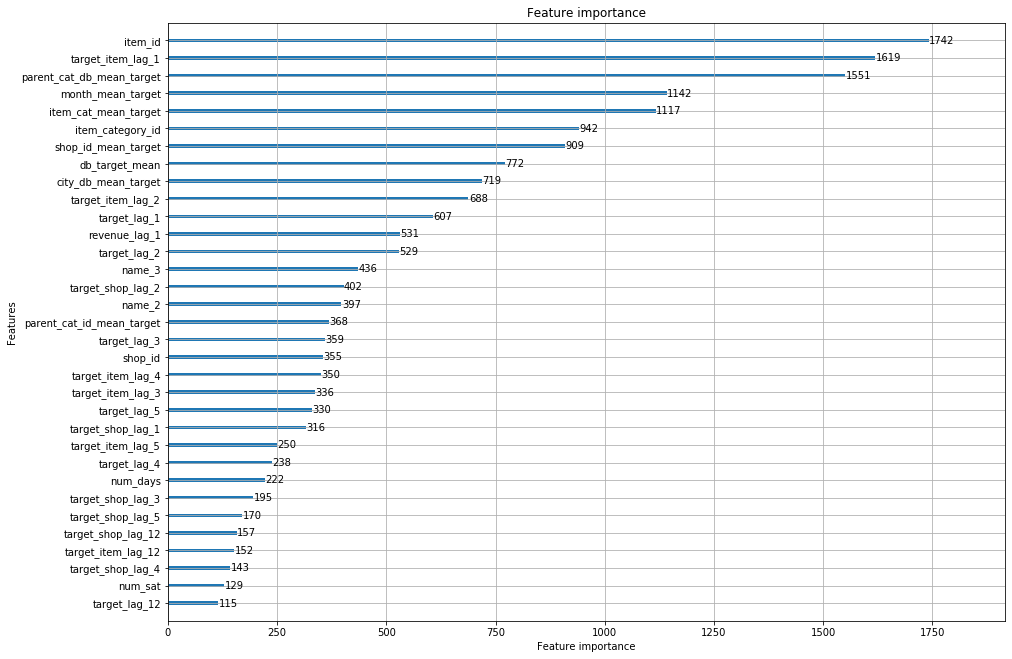

In [60]:
lgb.plot_importance(model, figsize=(15,11))

In [61]:
pred_lgb = model.predict(X_test).clip(0,20)
pred_lgb_valid = model.predict(X_valid).clip(0,20)

In [62]:
pred_lgb_valid.max(), pred_lgb.max()

(20.0, 19.767966745332803)

In [33]:
df_test['item_cnt_month'] = pred_lgb
df_submission= df_test[['ID','item_cnt_month']]
df_submission.to_csv('29jul2020_lgb_all_feat_22.csv', index=False)
#sales_util.save_submission('25jul2020_edx_lgb_2',df_submission)

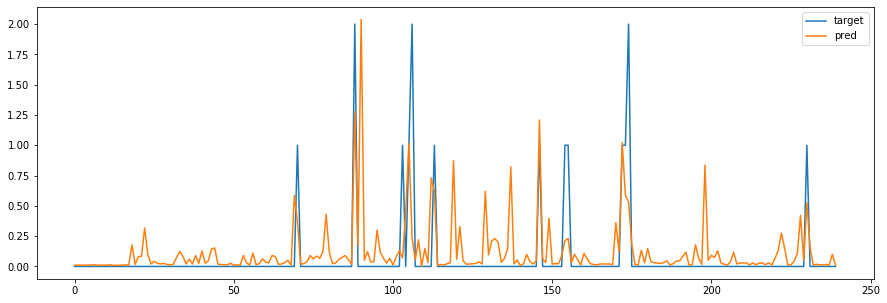

In [63]:
ytarget = y_valid[10:250]
ypred = pred_lgb_valid[10:250]
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ytarget, label='target')
ax.plot(ypred, label='pred')
ax.legend(loc='upper right')

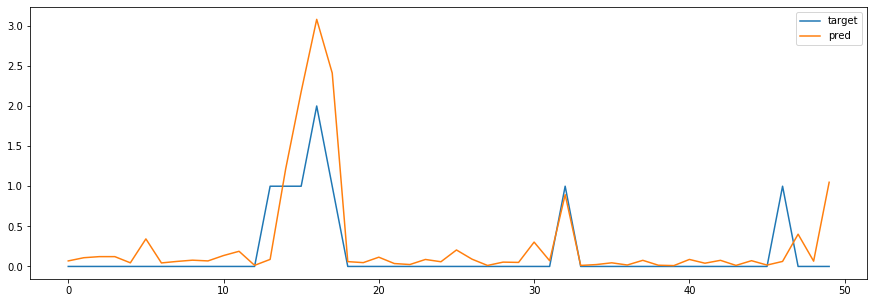

In [64]:
ytarget = y_valid[250:300]
ypred = pred_lgb_valid[250:300]
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ytarget, label='target')
ax.plot(ypred, label='pred')
ax.legend(loc='upper right')

In [41]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [42]:
mean_squared_error(y_valid, pred_lgb_valid)

0.8132204924007692

In [43]:
r2_score(y_valid, pred_lgb_valid)

0.3708846069449846

# Averaging

In [34]:
df_submission_17 = pd.read_csv('29jul2020_lgb_all_feat_17.csv')

In [36]:
df_submission_17.rename(columns={'item_cnt_month':'item_cnt_month_17'}, inplace=True)
df_submission.rename(columns={'item_cnt_month':'item_cnt_month_18'}, inplace=True)
df_avg = df_submission.merge(df_submission_17, how='inner')

In [37]:
df_avg.head()

,ID,item_cnt_month_18,item_cnt_month_17
0,0,0.345730,0.374155
1,1,0.166516,0.228877
2,2,0.614248,0.609159
3,3,0.253090,0.277104
4,4,1.936822,1.824504


In [38]:
df_avg['item_cnt_month'] = (df_avg['item_cnt_month_18'] + df_avg['item_cnt_month_17'])/2
df_avg.drop(['item_cnt_month_17','item_cnt_month_18'], axis=1, inplace=True)

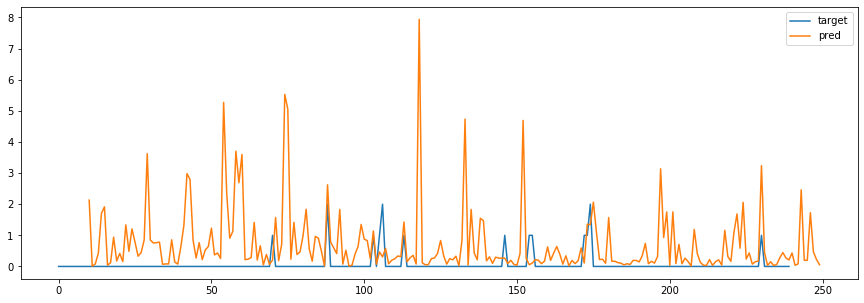

In [39]:
ytarget = y_valid[10:250]
ypred = df_avg.iloc[10:250]['item_cnt_month']
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ytarget, label='target')
ax.plot(ypred, label='pred')
ax.legend(loc='upper right')

In [41]:
df_avg.to_csv('29jul2020_lgb_all_feat_17_18_avg.csv', index=False)